#Efficient SAM Example

This script provides example for how to get visualization result from EfficientSAM using weight file, part of the code is borrow from MobileSAM project, many thanks!

##Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.transforms import ToTensor
from PIL import Image
import io

#Box and Point prompt

In [2]:
def run_ours_box_or_points(img_path, pts_sampled, pts_labels, model):
    image_np = np.array(Image.open(img_path))
    img_tensor = ToTensor()(image_np)
    pts_sampled = torch.reshape(torch.tensor(pts_sampled), [1, 1, -1, 2])
    pts_labels = torch.reshape(torch.tensor(pts_labels), [1, 1, -1])
    predicted_logits, predicted_iou = model(
        img_tensor[None, ...],
        pts_sampled,
        pts_labels,
    )

    sorted_ids = torch.argsort(predicted_iou, dim=-1, descending=True)
    predicted_iou = torch.take_along_dim(predicted_iou, sorted_ids, dim=2)
    predicted_logits = torch.take_along_dim(
        predicted_logits, sorted_ids[..., None, None], dim=2
    )

    return torch.ge(predicted_logits[0, 0, 0, :, :], 0).cpu().detach().numpy()

#Visualization Related

In [31]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.8])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(
        pos_points[:, 0],
        pos_points[:, 1],
        color="green",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )
    ax.scatter(
        neg_points[:, 0],
        neg_points[:, 1],
        color="red",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(
        plt.Rectangle((x0, y0), w, h, edgecolor="yellow", facecolor=(0, 0, 0, 0), lw=5)
    )

def show_anns_ours(mask, ax):
    ax.set_autoscale_on(False)
    img = np.ones((mask.shape[0], mask.shape[1], 4))
    img[:, :, 3] = 0
    color_mask = [0, 1, 0, 0.7]
    img[np.logical_not(mask)] = color_mask
    ax.imshow(img)


#Create the model and load the weights from the checkpoint.

In [4]:
!git clone https://github.com/yformer/EfficientSAM.git
import os
os.chdir("EfficientSAM")

Cloning into 'EfficientSAM'...
remote: Enumerating objects: 339, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 339 (delta 52), reused 37 (delta 37), pack-reused 284
Receiving objects: 100% (339/339), 222.75 MiB | 13.03 MiB/s, done.
Resolving deltas: 100% (194/194), done.
Updating files: 100% (35/35), done.


In [36]:
from efficient_sam.build_efficient_sam import build_efficient_sam_vitt, build_efficient_sam_vits
from squeeze_sam.build_squeeze_sam import build_squeeze_sam
import zipfile

efficient_sam_vitt_model = build_efficient_sam_vitt()
efficient_sam_vitt_model.eval()

# Since EfficientSAM-S checkpoint file is >100MB, we store the zip file.
with zipfile.ZipFile("weights/efficient_sam_vits.pt.zip", 'r') as zip_ref:
    zip_ref.extractall("weights")
efficient_sam_vits_model = build_efficient_sam_vits()
efficient_sam_vits_model.eval()

squeeze_sam_model = build_squeeze_sam()
squeeze_sam_model.eval()


SqueezeSam(
  (image_encoder): UnetEncoder(
    (proj): Sequential(
      (0): Conv2d(5, 64, kernel_size=(2, 2), stride=(2, 2))
      (1): GroupNorm(1, 64, eps=1e-05, affine=True)
    )
    (down_layers): ModuleList(
      (0): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2dWithActivation(
            (conv): Sequential(
              (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (1): ReLU()
            )
            (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (quant_output_normalization): QuantStub()
          )
          (1): Conv2dWithActivation(
            (conv): Sequential(
              (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (1): ReLU()
            )
            (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (quant_output_normalization): QuantStub()
          )
     

## Box segmentation

prepare your own image here

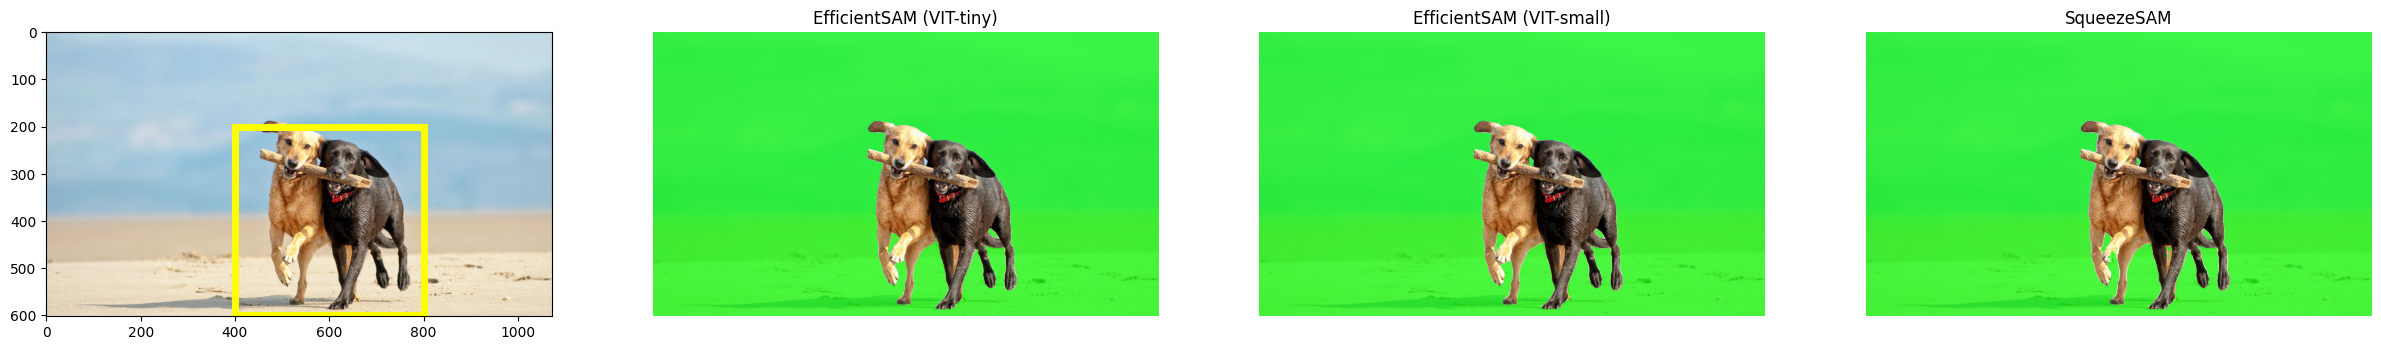

In [40]:
x1=400
y1=200
x2=800
y2=600
w=x2-x1
h=y2-y1

fig, ax = plt.subplots(1, 4, figsize=(30, 30))
input_point = np.array([[x1, y1], [x2, y2]])
input_label = np.array([2,3])
image_path = "figs/examples/dogs.jpg"
image = np.array(Image.open(image_path))
show_points(input_point, input_label, ax[0])
show_box([x1,y1,x2,y2], ax[0])
ax[0].imshow(image)


ax[1].imshow(image)
mask_efficient_sam_vitt = run_ours_box_or_points(image_path, input_point, input_label, efficient_sam_vitt_model)
show_anns_ours(mask_efficient_sam_vitt, ax[1])
ax[1].title.set_text("EfficientSAM (VIT-tiny)")
ax[1].axis('off')

ax[2].imshow(image)
mask_efficient_sam_vits = run_ours_box_or_points(image_path, input_point, input_label, efficient_sam_vits_model)
show_anns_ours(mask_efficient_sam_vits, ax[2])
ax[2].title.set_text("EfficientSAM (VIT-small)")
ax[2].axis('off')


ax[3].imshow(image)
mask_squeeze_sam = run_ours_box_or_points(image_path, input_point, input_label, squeeze_sam_model)
show_anns_ours(mask_squeeze_sam, ax[3])
ax[3].title.set_text("SqueezeSAM")
ax[3].axis('off')

plt.show()

## Point segmentation

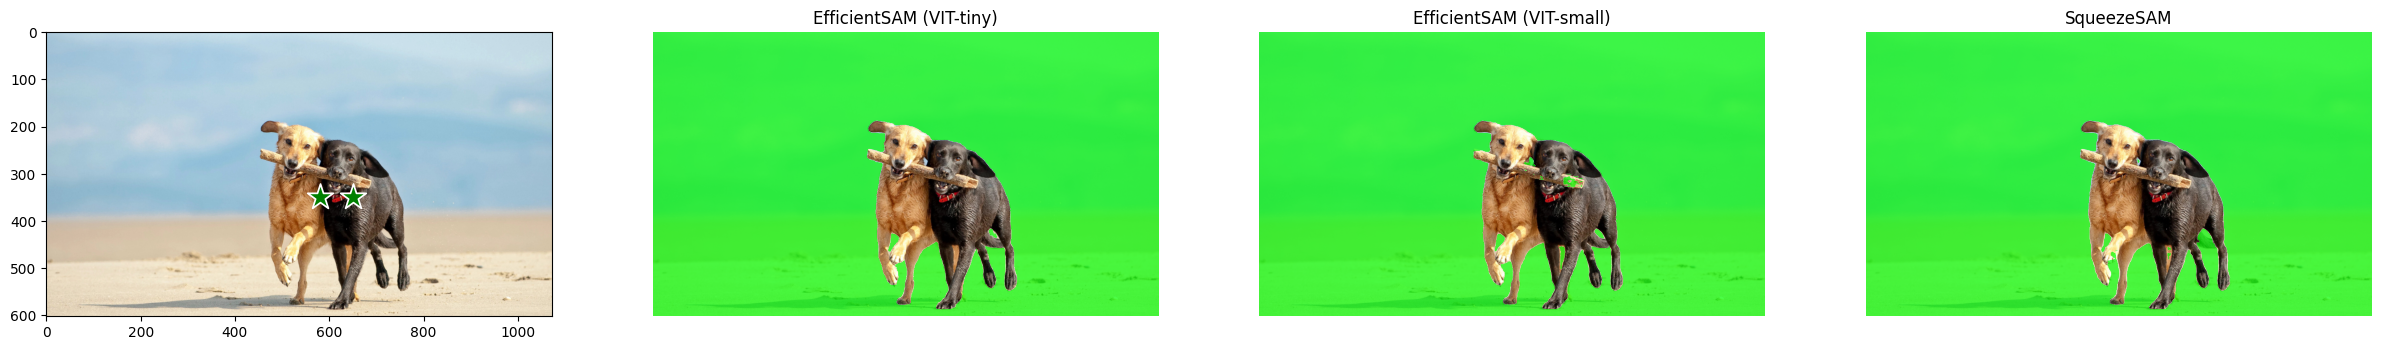

In [42]:
fig, ax = plt.subplots(1, 4, figsize=(30, 30))

input_label = np.array([1, 1])
image_path = "figs/examples/dogs.jpg"
input_point = np.array([[580, 350], [650, 350]])
image = np.array(Image.open(image_path))
show_points(input_point, input_label, ax[0])
ax[0].imshow(image)


ax[1].imshow(image)
mask_efficient_sam_vitt = run_ours_box_or_points(image_path, input_point, input_label, efficient_sam_vitt_model)
show_anns_ours(mask_efficient_sam_vitt, ax[1])
ax[1].title.set_text("EfficientSAM (VIT-tiny)")
ax[1].axis('off')

ax[2].imshow(image)
mask_efficient_sam_vits = run_ours_box_or_points(image_path, input_point, input_label, efficient_sam_vits_model)
show_anns_ours(mask_efficient_sam_vits, ax[2])
ax[2].title.set_text("EfficientSAM (VIT-small)")
ax[2].axis('off')


ax[3].imshow(image)
mask_squeeze_sam = run_ours_box_or_points(image_path, input_point, input_label, squeeze_sam_model)
show_anns_ours(mask_squeeze_sam, ax[3])
ax[3].title.set_text("SqueezeSAM")
ax[3].axis('off')

plt.show()